<a href="https://colab.research.google.com/github/bcury/Machine-Learning-Projects/blob/main/ML_an%C3%A1lises_Medicina_covid_DeepLearning_ResNet_ComputerVision_Image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Aplicando Machine Learning e Computação Visual em um problema de imagem para a Medicina

**Bibliotecas**

In [7]:
import pandas as pd
import os
import cv2 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
directory =  '/content/drive/MyDrive/Dataset-20211217T164718Z-001'

In [ ]:
os.listdir(directory)

In [ ]:
image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [5]:
133 * 4

532

In [6]:
532 / 40

13.3

In [ ]:
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_labels

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]],

In [ ]:
# Covid19 - 1 0 0 0
# Normal  - 0 1 0 0
# Viral   - 0 0 1 0
# Bacterial - 0 0 0 1
labels_names = {0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

Visualização dos dados

In [ ]:
np.arange(0, 36)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [ ]:
np.argmax(train_labels[0])

1

In [ ]:
labels_names[1]

'Normal'

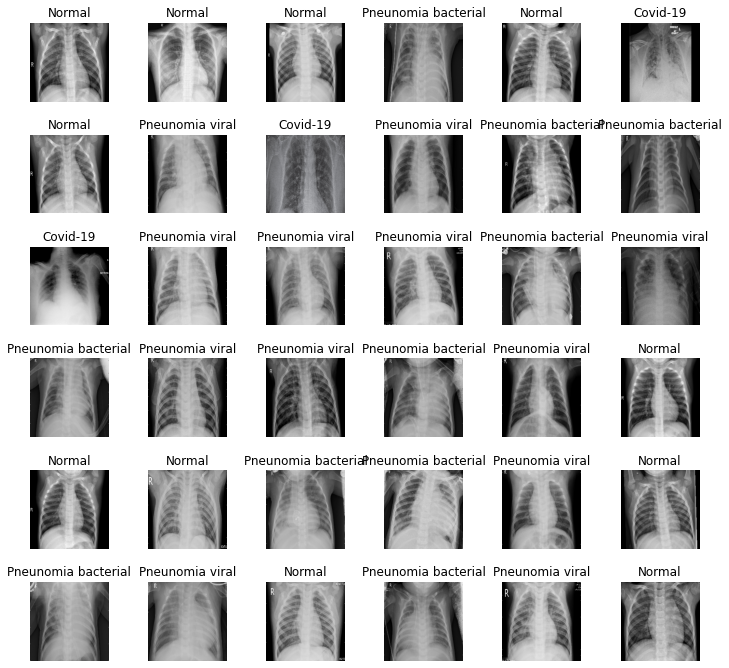

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

**Carregamento da rede neural com pesos pré-treinados**

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
len(base_model.layers)

175

In [ ]:
for layer in base_model.layers[:-10]:
  layers.trainable = False

**Construção e treinamento do modelo de deep learning**

In [ ]:
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [ ]:
model = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6),
              metrics = ['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(train_generator, epochs = 25, 
                              callbacks=[checkpointer])

Epoch 1/25
133/133 [==============================] - 33s 250ms/step - loss: 6.3621e-05 - accuracy: 1.0000
Epoch 2/25
133/133 [==============================] - 33s 245ms/step - loss: 0.0032 - accuracy: 0.9981
Epoch 3/25
133/133 [==============================] - 32s 244ms/step - loss: 1.6521e-06 - accuracy: 1.0000
Epoch 4/25
133/133 [==============================] - 33s 244ms/step - loss: 6.1158e-05 - accuracy: 1.0000
Epoch 5/25
133/133 [==============================] - 33s 245ms/step - loss: 7.5037e-06 - accuracy: 1.0000
Epoch 6/25
133/133 [==============================] - 33s 244ms/step - loss: 0.0207 - accuracy: 0.9981
Epoch 7/25
133/133 [==============================] - 33s 244ms/step - loss: 0.0422 - accuracy: 0.9962
Epoch 8/25
133/133 [==============================] - 33s 249ms/step - loss: 0.0634 - accuracy: 0.9925
Epoch 9/25
133/133 [==============================] - 33s 244ms/step - loss: 0.0242 - accuracy: 0.9962
Epoch 10/25
133/133 [==============================] - 33

**Avaliação da rede neural**

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

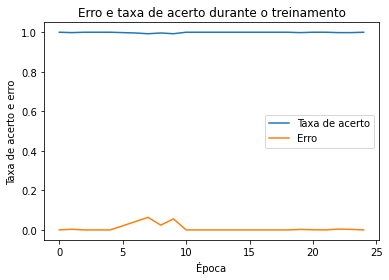

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [ ]:
test_directory = 'content/drive/MyDrive/Dataset-20211217T164718Z-001/test'

In [ ]:
os.listdir(test_directory)

['3', '2', '0', '1']

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [ ]:
evaluate = model.evaluate_generator(test_generator)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [ ]:
evaluate

[6.173990726470947, 0.800000011920929]

In [ ]:
len(os.listdir(test_directory))

4

In [ ]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [ ]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 2, 1, 3, 2, 3, 1, 3, 3, 3, 2, 3, 2, 3, 1]


In [ ]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
accuracy_score(original, prediction)

0.775

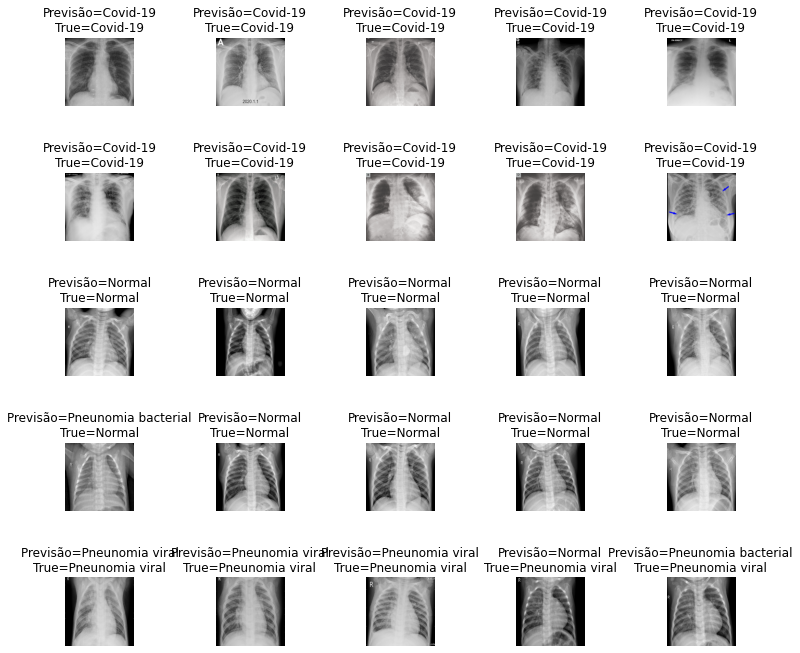

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

In [ ]:
labels_names

{0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

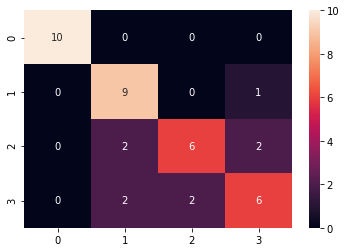

In [ ]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [ ]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.69      0.90      0.78        10
           2       0.75      0.60      0.67        10
           3       0.67      0.60      0.63        10

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.77        40



**Classificação de somente uma imagem**

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/weights.hdf5')

In [ ]:
model_loaded.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
4 * 4 * 2048

32768

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Dataset-20211217T164718Z-001'

In [ ]:
img, img.shape

(array([[[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        ...,
 
        [[196, 196, 196],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  3,   3,   3],
         [134, 134, 134]],
 
        [[187, 187, 187],
         [  5,   5,   5],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  7,   7,   7],
         [129, 129, 129]],
 
        [[214, 214, 214],
         [ 80,  80,  80],
         [ 87,  87,  87],
         ...,
         [ 80,  80,  80],
  

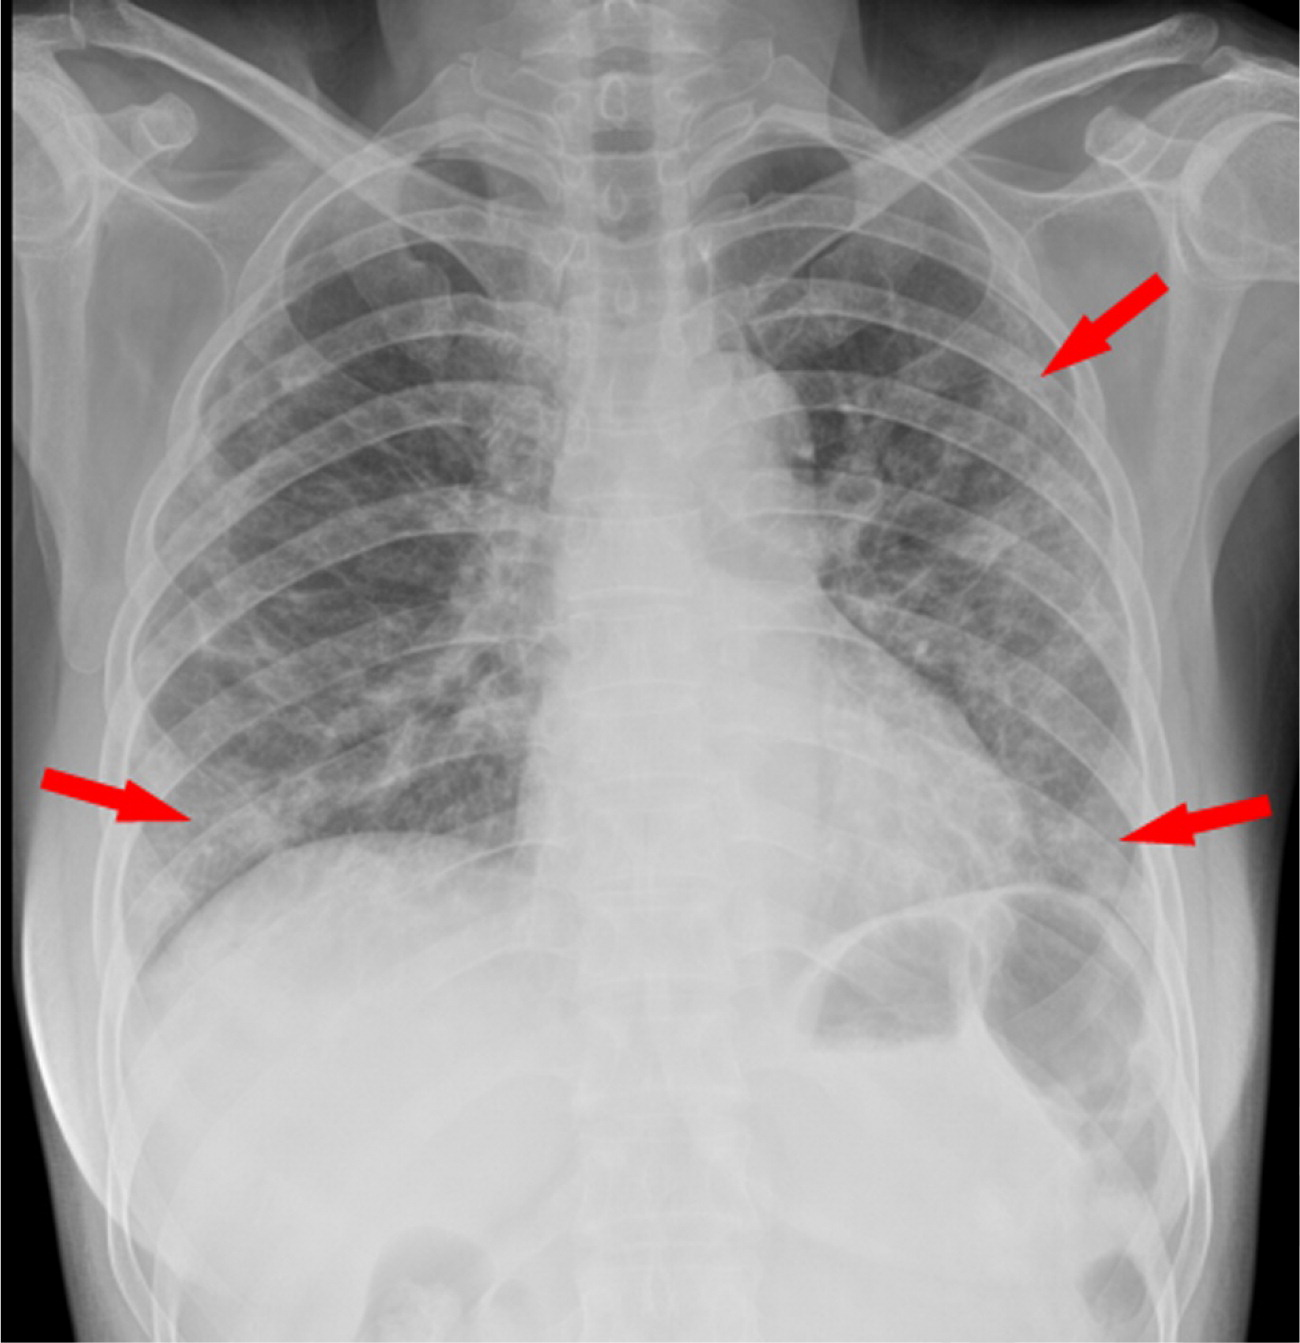

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

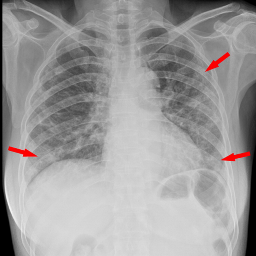

In [ ]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

In [ ]:
img = img / 255
img

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.10980392, 0.10980392, 0.10980392],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.12941176, 0.12941176, 0.12941176],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.16470588, 0.16470588, 0.16470588],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [ ]:
img.shape

(256, 256, 3)

In [ ]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [ ]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[1.0000000e+00, 1.3806964e-26, 0.0000000e+00, 7.0502489e-32]],
      dtype=float32)>

In [ ]:
predict2 = np.argmax(predict)
predict2

0

In [ ]:
labels_names[predict2], predict[0][predict2]

('Covid-19', <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)